## Import Libaries
- 

In [21]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import os
import glob

from random import sample, randint

from sklearn.model_selection import train_test_split

from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.applications.resnet_v2 import ResNet50V2

import easyocr

from lxml import etree

## Chargement du Dataset (Load Dataset)
Le Dataset contient 
- Les annotations sont des fichiers xml, qui contient les coordonnées des regions intérêt sur les images (les étiquettes) 
- Les differentes images des plaques d'immatriculations


In [22]:
#parcourir les fichiers images et dataset
src_path = "../dataset/input"
for dirName, _, fileNames in os.walk('../dataset/input'):
    for fileName in fileNames:
        print(os.path.join(dirName, fileName))

../dataset/input\annotations\Cars0.xml
../dataset/input\annotations\Cars1.xml
../dataset/input\annotations\Cars10.xml
../dataset/input\annotations\Cars100.xml
../dataset/input\annotations\Cars101.xml
../dataset/input\annotations\Cars102.xml
../dataset/input\annotations\Cars103.xml
../dataset/input\annotations\Cars104.xml
../dataset/input\annotations\Cars105.xml
../dataset/input\annotations\Cars106.xml
../dataset/input\annotations\Cars107.xml
../dataset/input\annotations\Cars108.xml
../dataset/input\annotations\Cars109.xml
../dataset/input\annotations\Cars11.xml
../dataset/input\annotations\Cars110.xml
../dataset/input\annotations\Cars111.xml
../dataset/input\annotations\Cars112.xml
../dataset/input\annotations\Cars113.xml
../dataset/input\annotations\Cars114.xml
../dataset/input\annotations\Cars115.xml
../dataset/input\annotations\Cars116.xml
../dataset/input\annotations\Cars117.xml
../dataset/input\annotations\Cars118.xml
../dataset/input\annotations\Cars119.xml
../dataset/input\annot

## Extraction
Extraire les informations
- Les images seront stocker dans une liste `X` 
- Les coordonnées seront extrait des annotations (étiquettes) et stocker dans un vecteur `y = [vx,vy]`

|  vx  |  vy  |
|------|------|
| xmin | ymin |
| xmax | ymax | 


#### Extraction d'images

In [23]:
# Définir taille d'image 
IMAGE_SIZE = 200

img_dir = src_path + "/images" ##"../input/car-plate-detection/images"
data_path = os.path.join(img_dir,'*g') # all files end with ...g (png, jpg, )
files = glob.glob(data_path)
files.sort()

X=[] # List des
for f1 in files:
    img = cv2.imread(f1)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    X.append(np.array(img))

#### Extraction des coordonnées (dans les annotations)

In [24]:
def resizeannotation(f):  # Fonction qui va extraire les informations des fichiers xml
    tree = etree.parse(f)
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text) / (width / IMAGE_SIZE)
        ymin = int(dim.xpath("ymin")[0].text) / (height / IMAGE_SIZE)
        xmax = int(dim.xpath("xmax")[0].text) / (width / IMAGE_SIZE)
        ymax = int(dim.xpath("ymax")[0].text) / (height / IMAGE_SIZE)
    return [int(xmax), int(ymax), int(xmin), int(ymin)]

In [25]:
path = src_path + '/annotations'
text_files = [src_path + '/annotations/'+f for f in sorted(os.listdir(path))] # Stocker les fichiers xml dans la liste

y=[] # List des coordonnées des regions intérêt
for i in text_files:
    y.append(resizeannotation(i))

In [26]:
#for img in text_files: print(img)
for img in X: print(img)

[[[142 115  60]
  [162 127  47]
  [173 147  90]
  ...
  [ 38  39  38]
  [ 44  43  42]
  [ 37  36  34]]

 [[132 110  58]
  [155 121  41]
  [141 117  65]
  ...
  [ 49  50  50]
  [ 46  47  44]
  [ 36  38  35]]

 [[132 114  69]
  [154 123  45]
  [144 126  80]
  ...
  [ 39  39  40]
  [ 50  49  46]
  [ 36  37  33]]

 ...

 [[ 39  47  70]
  [ 40  48  71]
  [ 41  49  72]
  ...
  [ 42  61  98]
  [ 46  66 100]
  [ 47  68 101]]

 [[ 43  51  74]
  [ 42  50  73]
  [ 40  48  71]
  ...
  [ 44  63 100]
  [ 46  65 102]
  [ 48  67 104]]

 [[ 44  52  75]
  [ 41  49  72]
  [ 37  45  68]
  ...
  [ 45  64 102]
  [ 45  64 102]
  [ 46  65 103]]]
[[[250 245 225]
  [252 244 225]
  [250 244 224]
  ...
  [254 255 254]
  [254 255 253]
  [254 254 254]]

 [[250 245 226]
  [250 244 225]
  [250 244 224]
  ...
  [254 254 253]
  [254 255 253]
  [254 255 254]]

 [[249 247 226]
  [247 244 224]
  [248 245 225]
  ...
  [252 254 253]
  [253 254 253]
  [254 255 254]]

 ...

 [[ 79  69  62]
  [ 79  69  62]
  [ 83  73  66]
  ..

## Afficher les images du dataset (Display Image Dataset)

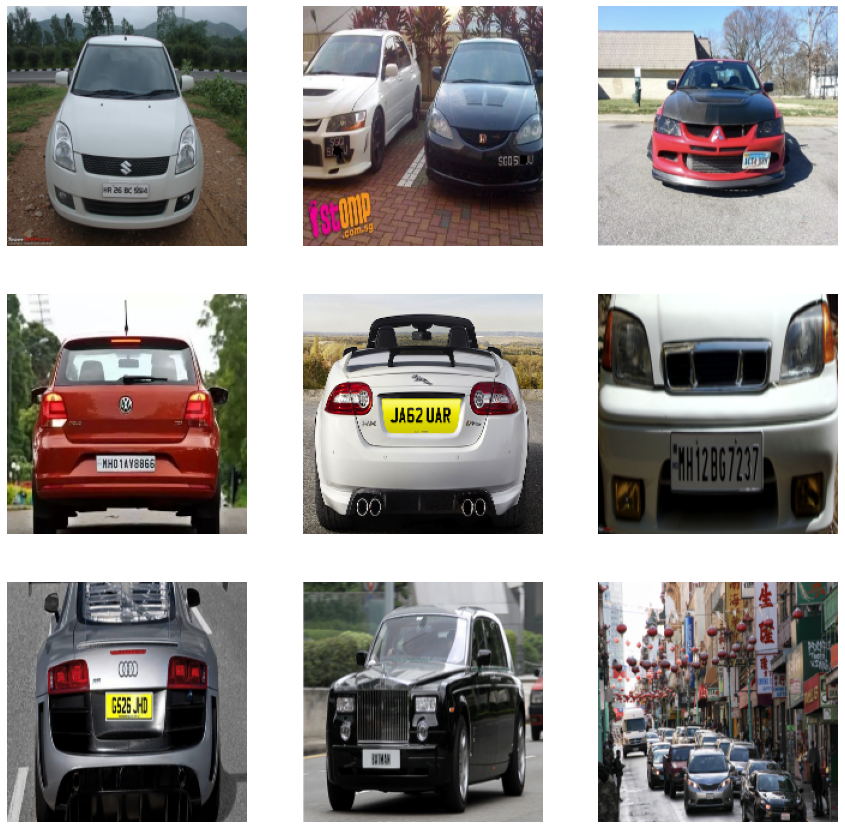

In [27]:
sample_index = []

for i in range(9):
    sample_index.append(randint(0, len(X)))

plt.figure(figsize=(15, 15))
for index, i in enumerate(sample_index):
    plt.subplot(3, 3, index + 1)
    plt.axis('off')
    plt.imshow(cv2.cvtColor(X[i], cv2.COLOR_BGR2RGB))

## Verifier la taille des images

In [28]:
print(f"X Shape : {np.array(X).shape}")
print(f"y Shape : {np.array(y).shape}")

X Shape : (433, 200, 200, 3)
y Shape : (433, 4)


## Afficher les images du dataset avec leurs annotations (région d'interêt) 

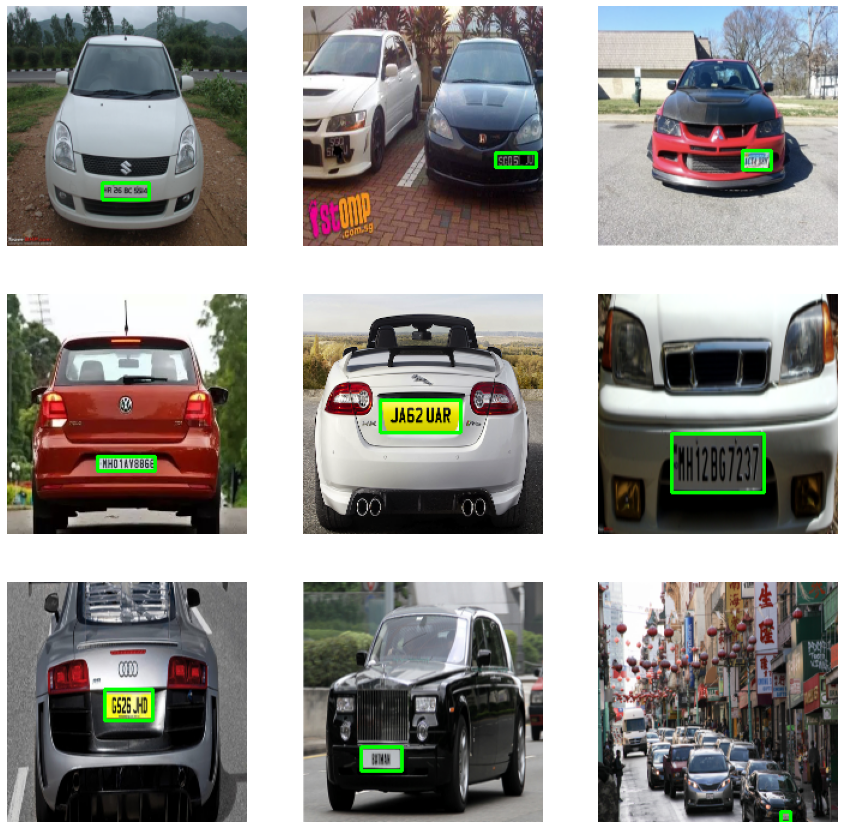

In [29]:
plt.figure(figsize=(15, 15))
for index, i in enumerate(sample_index):
    plt.subplot(3, 3, index + 1)
    image = cv2.rectangle(cv2.cvtColor(X[i], cv2.COLOR_BGR2RGB),(y[i][0],y[i][1]),(y[i][2],y[i][3]),(0, 255, 0), 2)
    plt.imshow(image)
    plt.axis("off")

plt.show()

In [30]:
for i in range(9):
    print(y[i])

[167, 129, 90, 93]
[131, 129, 67, 103]
[151, 131, 70, 4]
[107, 98, 87, 85]
[120, 146, 83, 134]
[184, 151, 37, 111]
[101, 123, 94, 118]
[97, 150, 78, 142]
[103, 132, 76, 122]


## Prétraitement des données (Data Preprocessing)

In [31]:
X = np.array(X)
y = np.array(y)

X = X / 255 # reduire les valeurs des X en valuer comprise entre 0.0 et 1.0 | pour être utilisé on multipliera par 255
y = y / 255 # reduire les valeurs de y 

<font size="3">Fractionnement des l'ensemble des données : (70% Entrainement, 10% Validation, 20% Testes) | Data Splitting (70% Training, 10% Validation, 20% Testing)</font>

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Test : 20%
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=1) # Validation : 10%

## Implémentation du modèle VGG19

In [33]:
model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(256, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64,  activation="relu"))
model.add(Dense(4,   activation="sigmoid"))

model.layers[-7].trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 18432)             0         
                                                                 
 dropout_1 (Dropout)         (None, 18432)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               4718848   
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 4)                

## Entrainement du modèle VGG19, 

#### Loss fonction : MSE (mean square error)
#### Optimizer : RMSprop


In [34]:
import keras.optimizers as  optimizers

In [35]:
optimizer = optimizers.RMSprop()
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=120, batch_size=32, verbose=1)

Epoch 1/120
10/10 [==============================] - 44s 4s/step - loss: 0.2226 - accuracy: 0.1358 - val_loss: 0.2485 - val_accuracy: 0.0000e+00
Epoch 2/120
10/10 [==============================] - 47s 5s/step - loss: 0.2328 - accuracy: 0.0000e+00 - val_loss: 0.2510 - val_accuracy: 0.0000e+00
Epoch 3/120
10/10 [==============================] - 47s 5s/step - loss: 0.2164 - accuracy: 0.3510 - val_loss: 0.2163 - val_accuracy: 0.5000
Epoch 4/120
10/10 [==============================] - 46s 5s/step - loss: 0.2142 - accuracy: 0.3576 - val_loss: 0.1657 - val_accuracy: 0.5000
Epoch 5/120
10/10 [==============================] - 46s 5s/step - loss: 0.0955 - accuracy: 0.3874 - val_loss: 0.0546 - val_accuracy: 0.5000
Epoch 6/120
10/10 [==============================] - 46s 5s/step - loss: 0.0274 - accuracy: 0.4768 - val_loss: 0.0290 - val_accuracy: 0.5000
Epoch 7/120
10/10 [==============================] - 46s 5s/step - loss: 0.0215 - accuracy: 0.5397 - val_loss: 0.0137 - val_accuracy: 0.6364
E

In [36]:
model.save('_rmsprop/vgg16_trained_model_rmsprop-2.h5')

## Evaluation 

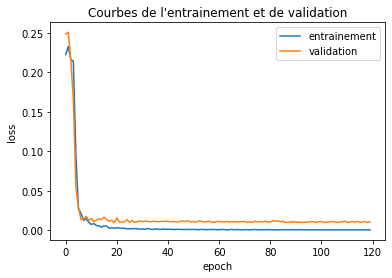

In [37]:
#plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Courbes de l\'entrainement et de validation') #('Training and validation loss curves (VGG19)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['entrainement', 'validation'], loc='upper right')
plt.show()

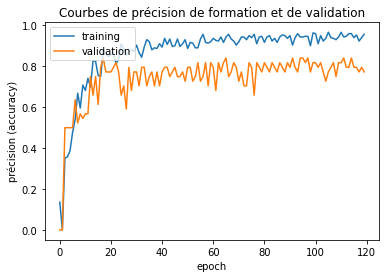

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Courbes de précision de formation et de validation') # ('Training and validation accuracy curves (VGG19)')
plt.ylabel('précision (accuracy)')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

## Teste du VGG19

In [39]:
test_loss, test_accuracy = model.evaluate(X_test, y_test,steps=int(100))
y_cnn = model.predict(X_test)

print("")
print(f"Loss : {test_loss * 100}%")
print(f"Accuracy : {test_accuracy * 100}%")

3/3 [==============================] - 26s 10s/step

Loss : 0.5589719396084547%
Accuracy : 85.05747318267822%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IndexError: index 87 is out of bounds for axis 0 with size 87

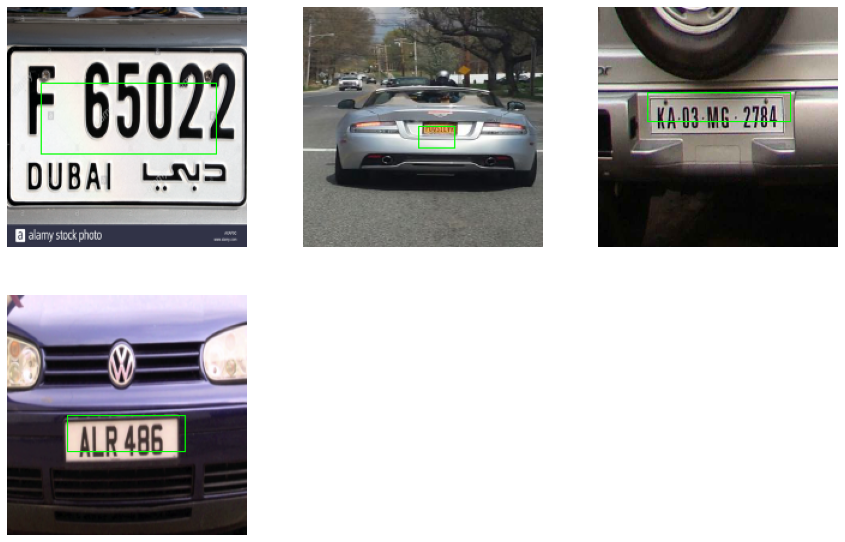

In [40]:
sample_index = []

img_list = []
for i in range(9):
    sample_index.append(randint(0, len(X_test)))

#text = easyocr.Reader(['en'])
plt.figure(figsize=(15, 15))
for index, i in enumerate(sample_index):
    plt.subplot(3, 3, index + 1)
    plt.axis('off')
    ny = np.copy(y_cnn[i])
    ny = ny * 255
    
    rgb_img = cv2.cvtColor(np.copy(X_test[i]).astype('float32'), cv2.COLOR_BGR2RGB)
    image = cv2.rectangle(rgb_img,(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 0))
    img_list.append(image)
    plt.imshow(image)
    
plt.show()

In [71]:
# Définir taille d'image 
IMAGE_SIZE = 200

img_dir = "../dataset/cd_test"
data_path = os.path.join(img_dir,'*g') # all files end with ...g (png, jpg, )
files = glob.glob(data_path)
files.sort()

plates=[] # List des
for f1 in files:
    img = cv2.imread(f1)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    plates.append(np.array(img))

In [1]:
n = len(plates)
plt.figure(figsize=(15, 15))
for i in range(n):
    plt.subplot(3, 3, i + 1)
    plt.axis('off')
    plt.imshow(cv2.cvtColor(plates[i], cv2.COLOR_BGR2RGB))

NameError: name 'plates' is not defined

In [73]:
plates = np.array(plates)
plates = plates / 255 

In [74]:
pred = model.predict(plates)

1/1 [==============================] - 1s 661ms/step


In [2]:
img_list = plates
length = len(img_list)
print("length : ", length)
plt.figure(figsize=(20, 20))
j=0
for i in range(6):
    plt.subplot(3, 3, i+1)
    plt.axis('off')
    ny = np.copy(pred[j])
    ny = ny * 255
    
    rgb_img = cv2.cvtColor(np.copy(img_list[j]).astype('float32'), cv2.COLOR_BGR2RGB)
    image = cv2.rectangle(rgb_img,(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 0))
    plt.imshow(image)
    j+=1
    
plt.show()


NameError: name 'plates' is not defined

# FIN du code